# Movielens Recommender

- Session based recommenders system
- Movielens 1M dataset

In [59]:
import datetime as dt
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

# Data Load

In [60]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3],
                      dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
    return data

In [262]:
data_path = Path(os.getenv('HOME')+'/aiffel/aiffel_projects/exploration/E12_yoochoose/data')
train_path = data_path / 'ratings.dat'

rating_data = load_data(train_path)
rating_data.sort_values(['user_id', 'timestamp'], inplace=True)

rating_data

,user_id,movie_id,rating,timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


<br>

# Data Exploration & Preprocess

## 1) user_id, movie_id

- user_id가 session_id 역할을 한다고 가정
- user_id별 movie_id가 몇 개 정도 되는지 분포 확인
- movie_id별 user_id가 몇 개 정도 되는지 분포 확인
- 100명 미만이 본 영화는 삭제

In [179]:
# user별 시청한 영화가 몇 편인지 분포를 확인
movies_per_user = rating_data.groupby('user_id')['movie_id'].size()

In [180]:
movies_per_user.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: movie_id, dtype: float64

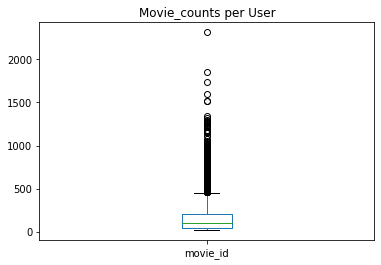

In [109]:
movies_per_user.plot(kind='box', title='Movie_counts per User')

plt.show()

In [263]:
# movie count별 user_id 개수
users_per_movie = rating_data.groupby('movie_id')['user_id'].size()

users_per_movie.describe()

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: user_id, dtype: float64

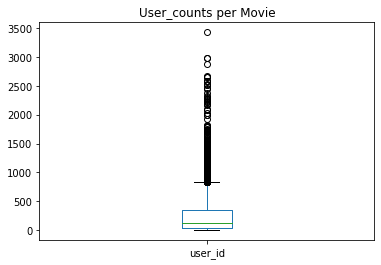

In [264]:
users_per_movie.plot(kind='box', title='User_counts per Movie')

plt.show()

In [265]:
users_per_movie = pd.DataFrame(users_per_movie)

users_per_movie

,user_id
movie_id,
1,2077
2,701
3,478
4,170
5,296
...,...
3948,862
3949,304
3950,54


In [266]:
# 100명 미만이 본 영화는 삭제
tmp_remove = users_per_movie.loc[users_per_movie['user_id'] < 100].index

tmp_remove

Int64Index([   8,   13,   27,   30,   33,   35,   37,   38,   40,   49,
            ...
            3939, 3940, 3941, 3942, 3943, 3944, 3945, 3947, 3950, 3951],
           dtype='int64', name='movie_id', length=1687)

In [267]:
data = rating_data[~rating_data['movie_id'].isin(tmp_remove)]

data.shape

(942225, 4)

## 2) Timestamp

- unix time -> datetime 변환
- datetime 분포 확인

In [274]:
data.reset_index(drop=True, inplace=True)

data

,user_id,movie_id,rating,timestamp
0,1,3186,4,978300019
1,1,1270,5,978300055
2,1,1721,4,978300055
3,1,1022,5,978300055
4,1,2340,3,978300103
...,...,...,...,...
942220,6040,2917,4,997454429
942221,6040,1921,4,997454464
942222,6040,1784,3,997454464
942223,6040,161,3,997454486


In [270]:
# unix time -> datetime 변환
datetime = data['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))

datetime

0        2000-12-31 22:00:19
1        2000-12-31 22:00:55
2        2000-12-31 22:00:55
3        2000-12-31 22:00:55
4        2000-12-31 22:01:43
                 ...        
942220   2001-08-10 14:40:29
942221   2001-08-10 14:41:04
942222   2001-08-10 14:41:04
942223   2001-08-10 14:41:26
942224   2001-08-20 13:44:15
Name: timestamp, Length: 942225, dtype: datetime64[ns]

In [275]:
tmp_df = pd.DataFrame(data=datetime.values, columns=['datetime'], index=datetime.index)

tmp_df

,datetime
0,2000-12-31 22:00:19
1,2000-12-31 22:00:55
2,2000-12-31 22:00:55
3,2000-12-31 22:00:55
4,2000-12-31 22:01:43
...,...
942220,2001-08-10 14:40:29
942221,2001-08-10 14:41:04
942222,2001-08-10 14:41:04
942223,2001-08-10 14:41:26


In [277]:
# index를 기준으로 join
data = data.join(tmp_df, how='outer')

data

,user_id,movie_id,rating,timestamp,datetime
0,1,3186,4,978300019,2000-12-31 22:00:19
1,1,1270,5,978300055,2000-12-31 22:00:55
2,1,1721,4,978300055,2000-12-31 22:00:55
3,1,1022,5,978300055,2000-12-31 22:00:55
4,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
942220,6040,2917,4,997454429,2001-08-10 14:40:29
942221,6040,1921,4,997454464,2001-08-10 14:41:04
942222,6040,1784,3,997454464,2001-08-10 14:41:04
942223,6040,161,3,997454486,2001-08-10 14:41:26


In [278]:
# 기존 timestamp column drop
data.drop('timestamp', axis=1, inplace=True)

data

,user_id,movie_id,rating,datetime
0,1,3186,4,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55
2,1,1721,4,2000-12-31 22:00:55
3,1,1022,5,2000-12-31 22:00:55
4,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29
942221,6040,1921,4,2001-08-10 14:41:04
942222,6040,1784,3,2001-08-10 14:41:04
942223,6040,161,3,2001-08-10 14:41:26


## 3) Session_id 부여

- user_id별 datetime min, max 차이를 초(sec) 단위로 확인
- 1 세션 = 30min = 1800s로 가정
- user_id별 timestamp.min을 첫 번째 session_id, 이후 1800s 단위로 순서대로 session_id를 부여

In [279]:
# user_id별 time.max() - time.min()
min_time = data.groupby('user_id')['datetime'].min()
max_time = data.groupby('user_id')['datetime'].max()

user_time_diff = max_time - min_time

user_time_diff

user_id
1        6 days 01:38:52
2        0 days 00:34:10
3        0 days 00:24:46
4        0 days 00:05:58
5        0 days 01:31:53
              ...       
6036     0 days 12:44:07
6037     1 days 01:47:23
6038     0 days 02:52:57
6039     0 days 14:41:11
6040   481 days 14:38:43
Name: datetime, Length: 6040, dtype: timedelta64[ns]

In [280]:
user_time_diff.describe()

count                           6040
mean      94 days 05:18:28.326986756
std      220 days 14:13:49.681434596
min                  0 days 00:01:46
25%                  0 days 00:20:05
50%           0 days 01:07:05.500000
75%          22 days 21:13:06.500000
max               1032 days 23:03:12
Name: datetime, dtype: object

In [285]:
diff_sec = user_time_diff.apply(lambda x: pd.Timedelta.total_seconds(x))

diff_sec

user_id
1         524332.0
2           2050.0
3           1486.0
4            358.0
5           5513.0
           ...    
6036       45847.0
6037       92843.0
6038       10377.0
6039       52871.0
6040    41611123.0
Name: datetime, Length: 6040, dtype: float64

In [286]:
diff_sec.describe()

count    6.040000e+03
mean     8.140708e+06
std      1.905923e+07
min      1.060000e+02
25%      1.205000e+03
50%      4.025500e+03
75%      1.977186e+06
max      8.924779e+07
Name: datetime, dtype: float64

In [301]:
# 대략적인 session 개수를 계산해보기
session_cnt = diff_sec / 1800

session_cnt

user_id
1         291.295556
2           1.138889
3           0.825556
4           0.198889
5           3.062778
            ...     
6036       25.470556
6037       51.579444
6038        5.765000
6039       29.372778
6040    23117.290556
Name: datetime, Length: 6040, dtype: float64

In [302]:
session_cnt.describe()

count     6040.000000
mean      4522.615737
std      10588.460934
min          0.058889
25%          0.669444
50%          2.236389
75%       1098.436944
max      49582.106667
Name: datetime, dtype: float64

In [288]:
data

,user_id,movie_id,rating,datetime
0,1,3186,4,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55
2,1,1721,4,2000-12-31 22:00:55
3,1,1022,5,2000-12-31 22:00:55
4,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29
942221,6040,1921,4,2001-08-10 14:41:04
942222,6040,1784,3,2001-08-10 14:41:04
942223,6040,161,3,2001-08-10 14:41:26


In [298]:
data = data.merge(min_time, how='outer', on='user_id')

data

,user_id,movie_id,rating,datetime_x,datetime_y
0,1,3186,4,2000-12-31 22:00:19,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55,2000-12-31 22:00:19
2,1,1721,4,2000-12-31 22:00:55,2000-12-31 22:00:19
3,1,1022,5,2000-12-31 22:00:55,2000-12-31 22:00:19
4,1,2340,3,2000-12-31 22:01:43,2000-12-31 22:00:19
...,...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29,2000-04-25 23:05:32
942221,6040,1921,4,2001-08-10 14:41:04,2000-04-25 23:05:32
942222,6040,1784,3,2001-08-10 14:41:04,2000-04-25 23:05:32
942223,6040,161,3,2001-08-10 14:41:26,2000-04-25 23:05:32


In [299]:
data.rename(columns={'datetime_x': 'datetime', 'datetime_y':'min_datetime'}, inplace=True)

data

,user_id,movie_id,rating,datetime,min_datetime
0,1,3186,4,2000-12-31 22:00:19,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55,2000-12-31 22:00:19
2,1,1721,4,2000-12-31 22:00:55,2000-12-31 22:00:19
3,1,1022,5,2000-12-31 22:00:55,2000-12-31 22:00:19
4,1,2340,3,2000-12-31 22:01:43,2000-12-31 22:00:19
...,...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29,2000-04-25 23:05:32
942221,6040,1921,4,2001-08-10 14:41:04,2000-04-25 23:05:32
942222,6040,1784,3,2001-08-10 14:41:04,2000-04-25 23:05:32
942223,6040,161,3,2001-08-10 14:41:26,2000-04-25 23:05:32


In [306]:
data['session_number'] = data.apply(lambda x: pd.Timedelta.total_seconds(x['datetime'] - x['min_datetime'])//1800, axis=1)

data

,user_id,movie_id,rating,datetime,min_datetime,session_number
0,1,3186,4,2000-12-31 22:00:19,2000-12-31 22:00:19,0.0
1,1,1270,5,2000-12-31 22:00:55,2000-12-31 22:00:19,0.0
2,1,1721,4,2000-12-31 22:00:55,2000-12-31 22:00:19,0.0
3,1,1022,5,2000-12-31 22:00:55,2000-12-31 22:00:19,0.0
4,1,2340,3,2000-12-31 22:01:43,2000-12-31 22:00:19,0.0
...,...,...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29,2000-04-25 23:05:32,22639.0
942221,6040,1921,4,2001-08-10 14:41:04,2000-04-25 23:05:32,22639.0
942222,6040,1784,3,2001-08-10 14:41:04,2000-04-25 23:05:32,22639.0
942223,6040,161,3,2001-08-10 14:41:26,2000-04-25 23:05:32,22639.0


In [332]:
final_data = data.groupby(['user_id', 'datetime'])['movie_id'].size().reset_index()

final_data

,user_id,datetime,movie_id
0,1,2000-12-31 22:00:19,1
1,1,2000-12-31 22:00:55,3
2,1,2000-12-31 22:01:43,1
3,1,2000-12-31 22:02:52,1
4,1,2000-12-31 22:04:35,1
...,...,...,...
454162,6040,2001-08-10 14:39:58,1
454163,6040,2001-08-10 14:40:29,1
454164,6040,2001-08-10 14:41:04,2
454165,6040,2001-08-10 14:41:26,1


## 4) rating

- movie별 mean, median, min, max rating 분포 확인
- 평균 rating이 3 미만인 영화는 삭제

In [198]:
r_mean = data.groupby('movie_id')['rating'].mean()
r_median = data.groupby('movie_id')['rating'].median()
r_min = data.groupby('movie_id')['rating'].min()
r_max = data.groupby('movie_id')['rating'].max()

ratings = {'mean': r_mean,
          'median': r_median,
          'min': r_min,
          'max': r_max}

ratings = pd.DataFrame(ratings)

ratings

,mean,median,min,max
movie_id,,,,
1,4.146846,4.0,1,5
2,3.201141,3.0,1,5
3,3.016736,3.0,1,5
4,2.729412,3.0,1,5
5,3.006757,3.0,1,5
...,...,...,...,...
3937,2.940741,3.0,1,5
3946,2.260000,2.0,1,5
3948,3.635731,4.0,1,5


In [199]:
ratings.loc[ratings['mean'] < 3]

,mean,median,min,max
movie_id,,,,
4,2.729412,3.0,1,5
9,2.656863,3.0,1,5
12,2.362500,2.0,1,5
15,2.458904,3.0,1,5
19,2.480720,2.0,1,5
...,...,...,...,...
3901,2.650943,3.0,1,5
3918,2.802395,3.0,1,5
3923,2.576923,3.0,1,5


In [200]:
tmp_remove = ratings.loc[ratings['mean'] < 3].index

tmp_remove

Int64Index([   4,    9,   12,   15,   19,   20,   23,   42,   44,   48,
            ...
            3841, 3864, 3877, 3879, 3889, 3901, 3918, 3923, 3937, 3946],
           dtype='int64', name='movie_id', length=488)

In [201]:
# 평점 3 미만인 영화 삭제
data = data[~data['movie_id'].isin(tmp_remove)]

data.groupby('movie_id')['rating'].mean()

movie_id
1       4.146846
2       3.201141
3       3.016736
5       3.006757
6       3.878723
          ...   
3932    3.750000
3936    3.723214
3948    3.635731
3949    4.115132
3952    3.780928
Name: rating, Length: 1531, dtype: float64

In [202]:
data.shape

(820721, 4)

In [203]:
data.head(10)

,user_id,movie_id,rating,datetime
31,1,3186,4,1970-01-01 00:00:00.978300019
22,1,1270,5,1970-01-01 00:00:00.978300055
27,1,1721,4,1970-01-01 00:00:00.978300055
37,1,1022,5,1970-01-01 00:00:00.978300055
24,1,2340,3,1970-01-01 00:00:00.978300103
36,1,1836,5,1970-01-01 00:00:00.978300172
3,1,3408,4,1970-01-01 00:00:00.978300275
7,1,2804,5,1970-01-01 00:00:00.978300719
47,1,1207,4,1970-01-01 00:00:00.978300719
0,1,1193,5,1970-01-01 00:00:00.978300760


## 4) Missing value

- 없으니까 넘어감

In [205]:
data.isna().sum()

user_id     0
movie_id    0
rating      0
datetime    0
dtype: int64

# Dataset Split

- 

### Train, Val, Test dataset split

- test set은 대회에서 제공
- 이번 자료에서는 가장 마지막 1일 기간 동안을 Test로, 2일전부터 1일전 까지를 valid set으로 나누겠습니다.


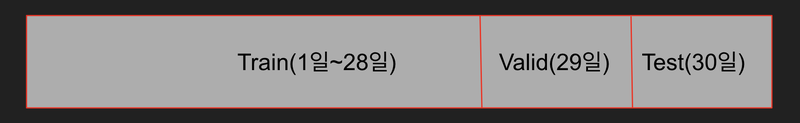

In [34]:
def split_by_date(data: pd.DataFrame, n_days: int):
    # data의 가장 마지막 timestamp
    final_time = data['Time'].max()
    
    # sessionId별 마지막 timestamp
    session_last_time = data.groupby('SessionId')['Time'].max()
    
    # final_time보다 n_days 이전 날짜까지를 train session으로 지정
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    
    # final_time에서 n_days 이후부터 test session으로 지정
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [35]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [38]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [39]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [40]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [41]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [44]:
test

,SessionId,Time,ItemId,item_idx
32230216,11255568,2014-09-29 13:30:47.554000+00:00,214696432,2513
32230217,11255568,2014-09-29 13:59:52.543000+00:00,214857030,7285
32230221,11255571,2014-09-29 06:41:24.881000+00:00,214858854,19974
32230222,11255571,2014-09-29 06:41:29.168000+00:00,214858854,19974
32230223,11255572,2014-09-29 16:50:10.726000+00:00,214836819,2298
...,...,...,...,...
32230529,11562142,2014-09-30 01:02:58.277000+00:00,214846865,15077
32230530,11562142,2014-09-30 01:05:32.361000+00:00,214848039,15078
32230531,11562142,2014-09-30 01:06:11.997000+00:00,214846865,15077
32230532,11562142,2014-09-30 01:07:18.136000+00:00,214855012,19576


## GRU4REC

- [논문 링크](https://arxiv.org/pdf/1511.06939v4.pdf)
- 여러 RNN 계열의 모델(e.g. LSTM)이 있겠지만 저자가 실험해본 결과 GRU의 성능이 제일 좋았다고 합니다.
- 또한 Embedding Layer를 사용하지 않았을 때가 사용했을 때보다 성능이 좋았다고 합니다.
- 이번 자료에서도 Embedding Layer를 사용하지 않고 One-hot Encoding만 사용하겠습니다.

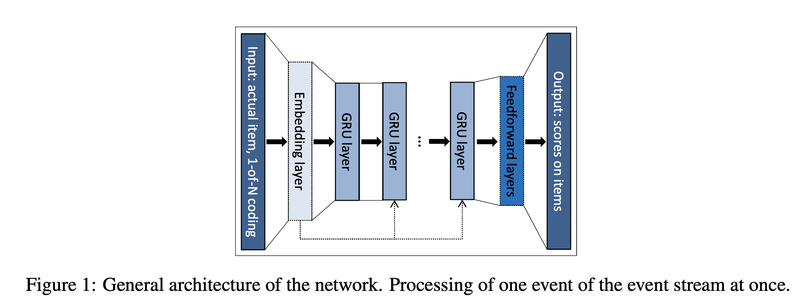

### SAMPLING ON THE OUTPUT

- Negative Sampling와 같은 개념입니다. Item의 수가 많기 때문에 Loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려하여 Sampling합니다. 이번 자료에서는 구현하지 않았습니다.

### Ranking Loss

- Session-Based Recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 Classification하는 Task로 생각할 수도 있습니다.
- 그러나 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있습니다.
- 추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용했습니다.
- 그러나 이번 자료에서는 Classification Task로 보고 Cross-Entropy Loss를 사용하겠습니다.

In [45]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [46]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [47]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [48]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

In [49]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [50]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [51]:
iter_ex = iter(tr_data_loader)

In [59]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [37  8 41 35]
Label Item Idx are :       [38  8 41 36]
Previous Masked Input Idx are [0 2]


## Modeling

### Evaluation Metric

- Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.
-  때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.
- 추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.
- 따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.
- 이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.
- 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입니다.
- NDCG, MRR, MAP에 대한 자세한 설명은 [링크](https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832)를 확인해주세요.

In [60]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture


In [62]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [63]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [64]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [65]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [66]:
train_model(model, args)

Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 1: 0.447122
	 - MRR@20    epoch 1: 0.165558



Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 2: 0.600327
	 - MRR@20    epoch 2: 0.244915



Evaluation:  77%|███████▋  | 17/22 [02:19<00:40,  8.18s/it]

	 - Recall@20 epoch 3: 0.662196
	 - MRR@20    epoch 3: 0.283552



In [68]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  81%|████████▏ | 22/27 [03:04<00:41,  8.37s/it]

	 - Recall@20: 0.660378
	 - MRR@20: 0.273778

